In [1]:
import numpy as np

import time

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions as tdist
import torch.autograd as autograd
from torch.autograd import Variable

from geomloss import SamplesLoss
from scipy.optimize import minimize
from imageio import imread
from random import choices

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


C:\Users\de-la\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

# 1. Principle

## 1.1. Problem formulation

In this section, we present how to pratically compute the deformation between two empirical measures $\alpha_n := n^{-1} \sum^n_{i=1} \delta_{x_i}$ and $\beta_n := n^{-1} \sum^n_{i=1} \delta_{y_i}$. This amounts to minimize the objective function,
$$
    J_{\lambda,n}(v) = S({\phi^v_1}_\sharp \alpha_n,\beta_n) + \lambda ||v||^2_{L^2_V},
$$
where for any $1 \leq i \leq n$ and $x \in \mathbb{R}^d$,
$$
    \phi^v_t(x) = x + \int^t_0 v_s(\phi^v_s(x)) ds.
$$
Using the reduction principle, we can represent any solution $v$ as,
$$
    v_t(x) = \sum^{n}_{j=1} K(x,z_j(t)) a_j(t),
$$
where $K : \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}^{d \times d}$ is the positive kernel characterizing $V$, and $a : t \in [0,1] \mapsto (a_1(t),...,a_{n}(t)) \in (\mathbb{R}^d)^{n}$ is the so-called momenta function, parametrizing the vector field. This kernel trick enables to reframe the minimization problem. For a given $a$, define the transformation of $\alpha_n$ at instant $t$ as,
$$
    \alpha(t) := n^{-1} \sum^n_{i=1} \delta_{z^a_i(t)},
$$
where for any $1 \leq i \leq n$,
$$
\begin{cases}
    z^a_i(0) = x_i, \\
    \dot{z}^a_i(t) = \sum^{n}_{j=1} K(z^a_i(t),z^a_j(t)) a_j(t).
\end{cases}
$$
Then, we aim at minimizing,
$$
    E_{\lambda,n}(a) = S(\alpha(1),\beta_n) + \gamma \int^1_0 \sum^{n}_{i,j=1} a_i(t)^T K(z_i(t),z_j(t)) a_j(t) dt.
$$
In our case we work with,
$$
    K(x,y) := \frac{1}{\sqrt{2 \pi \sigma}} e^{\frac{||x-y||^2}{2 \sigma^2}} I_d,
$$
where $\sigma$ is a hyperparameter.

## 1.2. Solving procedure

For practical reasons, we discretize the time scale $[0,1]$ into $\tau$ sub-intervals of equal sizes. More precisely, $a$ and $z^a$ becomes $(\tau+1) \times n \times d$ tensors indexed by $\{0,\ldots,\tau\}$ along the first dimension. The gradient of $E_{\lambda,n}$ is given by $\nabla E_{\lambda,n}(a) = 2\gamma a - p^a$ where for every $1 \leq i \leq n$

$$
\begin{cases}
    z^a_i(0) = x^0_i,\\
    z^a_i(t+1) = z^a_i(t) + \frac{1}{\tau} \sum^n_{j=1} K(z^a_i(t),z^a_j(t))a_j(t),\\
    p^a_i(\tau-1) = - \nabla_{z^a_i(1)} S(\mu^n_a(1),\mu_1),\\
    p^a_i(t-1) = p^a_i(t) + \frac{1}{\tau} \frac{1}{\sigma^2} \sum^n_{j=1} K(z^a_i(t),z^a_j(t))(a_i(t) \cdot p^a_j(t) + a_j(t) \cdot p^a_i(t) - 2 \lambda a_i(t) \cdot p_j(t))(z^a_i(t)-z^a_j(t)),\\ 
\end{cases}
$$

The quantity $\nabla_{z^a_i(1)} S(\mu^n_a(1),\mu_1)$ can be obtained either by using the closed-form or by automatic differentation. We use the GeomLoss package to manipulate the Sinkhorn divergence as well as other loss functions: 
https://www.kernel-operations.io/geomloss/

# 2. Implementation

## 2.1. Parameters

**To completely define the optimization problem one must specify:**

- $\varepsilon$ and $C$ the hyperparameters of $S$,
- $\sigma$ the bandwidth of the Gaussian kernel,
- $\lambda$ the regularization parameter (weight given to the kinetic energy penalty),
- $\tau$ the number of time steps (deformation starts at $t=0$ and ends at $t=\tau$).

**For the gradient descent one must choose:**

- the learning rate $lr$ parameter for the gradient descent.
- _max_iter_ the maximum number of iterations for the gradient descent.

We give some guidelines for the choice of the parameters:

- A too big $\sigma$ will only translate the point cloud, while a too small one will not interpolate and make the deformation inexistant. One have to test some values;
- The gradients of $S$ can be small, do not hesitate to choose a large $lr$. Adapt the value by looking at the first iterations of the descent. The good choice of $lr$ is very sensitive to the value of $\sigma$;
- The number of iterations until convergence can vary a lot depending on the other parameters.

## 2.2. Main functions

Note that key parts of the code come directly from the example section of the GeomLoss website: https://www.kernel-operations.io/geomloss/_auto_examples/index.html

In [3]:
def ShowShapesPCA(x,y):
   
    n,d = x.shape
    m,d = y.shape
    xy = np.concatenate([x,y],axis=0)
 
    #compute the projection vectors
    if d==2:
        Axis1=np.array([1,0])
        Axis2=np.array([0,1])
    else:
        U, Sigma, Vt = np.linalg.svd(xy)
        Axis1=Vt[0,:]
        Axis2=Vt[1,:]
   
    #project xy
    xy_p1=np.dot(xy,Axis1)
    xy_p2=np.dot(xy,Axis2)
 
    #generate the figure
    colors = ['r']*n+['b']*m
 
    fig, ax = plt.subplots()
 
    ax.scatter(xy_p1,xy_p2, c=colors, alpha=0.2)
 
    ax.set_xlabel('Axis 1', fontsize=15)
    ax.set_ylabel('Axis 2', fontsize=15)
    ax.set_title('2D projection of the data')
   
    #plt.xlim(-lim,lim)
    #plt.ylim(-lim,lim)

    plt.show()
   
    return Axis1, Axis2

In [4]:
def load_image(fname):
    img = imread(fname, as_gray=True)  # Grayscale
    img = (img[::-1, :]) / 255.0
    return 1 - img

def draw_samples(fname, n, dtype=torch.FloatTensor):
    A = load_image(fname)
    xg, yg = np.meshgrid(np.linspace(0, 1, A.shape[0]), np.linspace(0, 1, A.shape[1]))

    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()
    dots = np.array(choices(grid, dens, k=n))
    dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return torch.from_numpy(dots).type(dtype)

def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")
    
def plot_particles(ax, x, y, colors):
    plt.set_cmap("hsv")
    plt.scatter(
        [10], [10]
    )  # shameless hack to prevent a slight change of axis...

    display_samples(ax, y, [(0.55, 0.55, 0.95)])
    cloud = display_samples(ax, x, colors)

    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([], [])
    plt.yticks([], [])
    return cloud

In [5]:
def learn_diffeo(loss,x,y,lamb,sigma,tau,lr,max_iter,tol):
    
    # Use colors to identify the particles
    #colors = (10 * x[:, 0]).cos() * (10 * x[:, 1]).cos()
    #colors = colors.detach().cpu().numpy()
    #plt.figure(figsize=(12, 8))
    
    n,d = x.shape

    a = torch.zeros([tau+1,n,d], dtype=torch.float64).float()
    p = torch.zeros([tau+1,n,d], dtype=torch.float64).float()
    z = torch.zeros([tau+1,n,d], dtype=torch.float64).float()

    z[0] = x

    t0 = time.time()
    
    objective = loss(x,y).item()
    back = objective+1
    it = 0
    #k=1
    while (it<max_iter) and (objective>tol) and (objective<=back):
        back = objective   
        "Transform the inputs"
        s=0
        K = torch.zeros([tau+1,n,n])
        for t in range(tau): # t+1 in (1,2,...,tau)
            K[t] = (0.3989/sigma)*torch.exp(-torch.sum((z[t,:, None, :] - z[t,None, :, :])**2, dim=2) / (2 * sigma ** 2))
            Ka_t = K[t]@a[t]
            z[t+1] = z[t] + (1/tau)*Ka_t
            s = s + (1/tau)*torch.sum(a[t]@(Ka_t.t()))

        "Print the values"
        z1 = z[tau]
        z1.requires_grad = True
        
        loss_value = loss(z1,y)
        objective = loss(z1,y) + lamb*s
        #norm_grad = torch.sum((2*gamma*a+p)*(2*gamma*a+p))
        
        print("Iteration: "+str(it)+"  Fidelity loss: "+str(loss_value.item())+"  Objective: "+str(objective.item()))
        #if it%20==0:
            #ShowShapesPCA(z1.detach().numpy(),y)
            #ax = plt.subplot(2,3,k)
            #k = k + 1
            #plot_particles(ax, z1, y, colors)
            #plt.tight_layout()
            #ax.set_title("gradient step = {:1.2f}".format(lr * it))

        "Initialize p"
        [g] = torch.autograd.grad(loss_value, [z1])
        p[tau-1] = g

        "Solve the equation on p"
        for t in range(tau-1,0,-1): # t-1 in (tau-2,...,1,0)
            Ot = a[t]@(p[t].t())+p[t]@(a[t].t())-2*lamb*a[t]@(a[t].t())
            KOt = K[t]*Ot
            zi_term = z[t]*(KOt.sum(dim=1)[:,None]) # multiplying each row i of the n*d matrix z by the scalar sum_j Kij*Oij
            zj_term = KOt@z[t] # computing [sum_j (Kij*Oij)*zj]_i
            p[t-1] = p[t] + (1/tau)*(1/sigma**2)*(zi_term-zj_term)

        "Update the gradient descent"
        a = a - lr*(2*lamb*a+p)
        it += 1
    
    tf = time.time()
    print("Elapsed time: "+str(tf-t0))
    print("Averaged elapsed time per iteration: "+str((tf-t0)/it))
    
    return a,z

In [6]:
def apply_diffeo(x_new,y,a,z,title):

    "Initialization"
    m = x_new.shape[0]
    tau,n,d = z.shape
    tau=tau-1
    z_new = torch.zeros([tau+1,m,d])
    z_new[0] = x_new
    K = torch.zeros([tau+1,m,n])
    
    # Use colors to identify the particles
    colors = (10 * x_new[:, 0]).cos() * (10 * x_new[:, 1]).cos()
    colors = colors.detach().cpu().numpy()
    plt.figure(figsize=(24, 16))
    
    k=1
    ax = plt.subplot(3,tau//4+1,k)
    k = k + 1
    plot_particles(ax, z_new[0], y, colors)
    plt.tight_layout()
    ax.set_title("t = 0/{}".format(tau))

    "Iterations"
    for t in range(tau): # t+1 in (1,2,...,tau+1)
        K[t] = (0.3989/sigma)*torch.exp(-torch.sum((z_new[t,:, None, :] - z[t,None, :, :])**2, dim=2) / (2 * sigma ** 2))
        z_new[t+1] = z_new[t] + (1/(tau-1))*(K[t]@a[t])
        
        if (t+1)%2==0:
            #ShowShapesPCA(z_new[t+1],y)
            ax = plt.subplot(3,tau//4+1,k)
            k = k + 1
            plot_particles(ax, z_new[t+1], y, colors)
            plt.tight_layout()
            ax.set_title("t = {}/{}".format(t+1,tau))
    
    plt.savefig(title)

    return z_new[tau]

## 2.3. Experiments

In [7]:
n = 1000
x = draw_samples("density_a.png", n, dtype)
y = draw_samples("density_b.png", n, dtype)

m = 2000
x_new = draw_samples("density_a.png", m, dtype)
y_new = draw_samples("density_b.png", m, dtype)

### 2.3.1. (Unbiased) Sinkhorn divergence

In [8]:
tau = 16
lamb = 1e-8
sigma = 0.175

In [9]:
max_iter = 200
tol = 1e-8
lr = 0.5
S = SamplesLoss("sinkhorn", p=2, blur=0.01)

In [10]:
a,z = learn_diffeo(S,x,y,lamb,sigma,tau,lr,max_iter,tol)

Iteration: 0  Fidelity loss: 0.12741892039775848  Objective: 0.12741892039775848
Iteration: 1  Fidelity loss: 0.018541768193244934  Objective: 0.01854255422949791
Iteration: 2  Fidelity loss: 0.009667351841926575  Objective: 0.009668606333434582
Iteration: 3  Fidelity loss: 0.0066531384363770485  Objective: 0.006654680240899324
Iteration: 4  Fidelity loss: 0.004964402411133051  Objective: 0.004966139327734709
Iteration: 5  Fidelity loss: 0.0038517978973686695  Objective: 0.0038536719512194395
Iteration: 6  Fidelity loss: 0.0030983854085206985  Objective: 0.0031003563199192286
Iteration: 7  Fidelity loss: 0.0025752070359885693  Objective: 0.002577246632426977
Iteration: 8  Fidelity loss: 0.0022057427559047937  Objective: 0.0022078319452703
Iteration: 9  Fidelity loss: 0.0019423388876020908  Objective: 0.0019444640493020415
Iteration: 10  Fidelity loss: 0.0017558778636157513  Objective: 0.0017580293351784348
Iteration: 11  Fidelity loss: 0.0016205095453187823  Objective: 0.00162267987616

Iteration: 96  Fidelity loss: 0.0004005644004791975  Objective: 0.0004027977993246168
Iteration: 97  Fidelity loss: 0.0003982993366662413  Objective: 0.00040053334669210017
Iteration: 98  Fidelity loss: 0.00039604149060323834  Objective: 0.00039827608270570636
Iteration: 99  Fidelity loss: 0.00039379685767926276  Objective: 0.00039603200275450945
Iteration: 100  Fidelity loss: 0.0003915703564416617  Objective: 0.0003938060544896871
Iteration: 101  Fidelity loss: 0.000389367196476087  Objective: 0.000391603447496891
Iteration: 102  Fidelity loss: 0.0003871871158480644  Objective: 0.00038942391984164715
Iteration: 103  Fidelity loss: 0.00038503832183778286  Objective: 0.0003872756497003138
Iteration: 104  Fidelity loss: 0.0003829173801932484  Objective: 0.00038515523192472756
Iteration: 105  Fidelity loss: 0.00038082493119873106  Objective: 0.00038306330679915845
Iteration: 106  Fidelity loss: 0.0003787623718380928  Objective: 0.0003810012713074684
Iteration: 107  Fidelity loss: 0.000376

Iteration: 190  Fidelity loss: 0.00025347521295771003  Objective: 0.00025573011953383684
Iteration: 191  Fidelity loss: 0.0002524576848372817  Objective: 0.0002547124749980867
Iteration: 192  Fidelity loss: 0.00025144655955955386  Objective: 0.00025370120420120656
Iteration: 193  Fidelity loss: 0.000250441487878561  Objective: 0.0002526960161048919
Iteration: 194  Fidelity loss: 0.00024943926837295294  Objective: 0.0002516936219763011
Iteration: 195  Fidelity loss: 0.0002484407159499824  Objective: 0.00025069492403417826
Iteration: 196  Fidelity loss: 0.0002474472566973418  Objective: 0.0002497012901585549
Iteration: 197  Fidelity loss: 0.00024645798839628696  Objective: 0.0002487118181306869
Iteration: 198  Fidelity loss: 0.00024547308566980064  Objective: 0.00024772671167738736
Iteration: 199  Fidelity loss: 0.00024449333432130516  Objective: 0.0002467467566020787
Elapsed time: 309.7877080440521
Averaged elapsed time per iteration: 1.5489385402202607


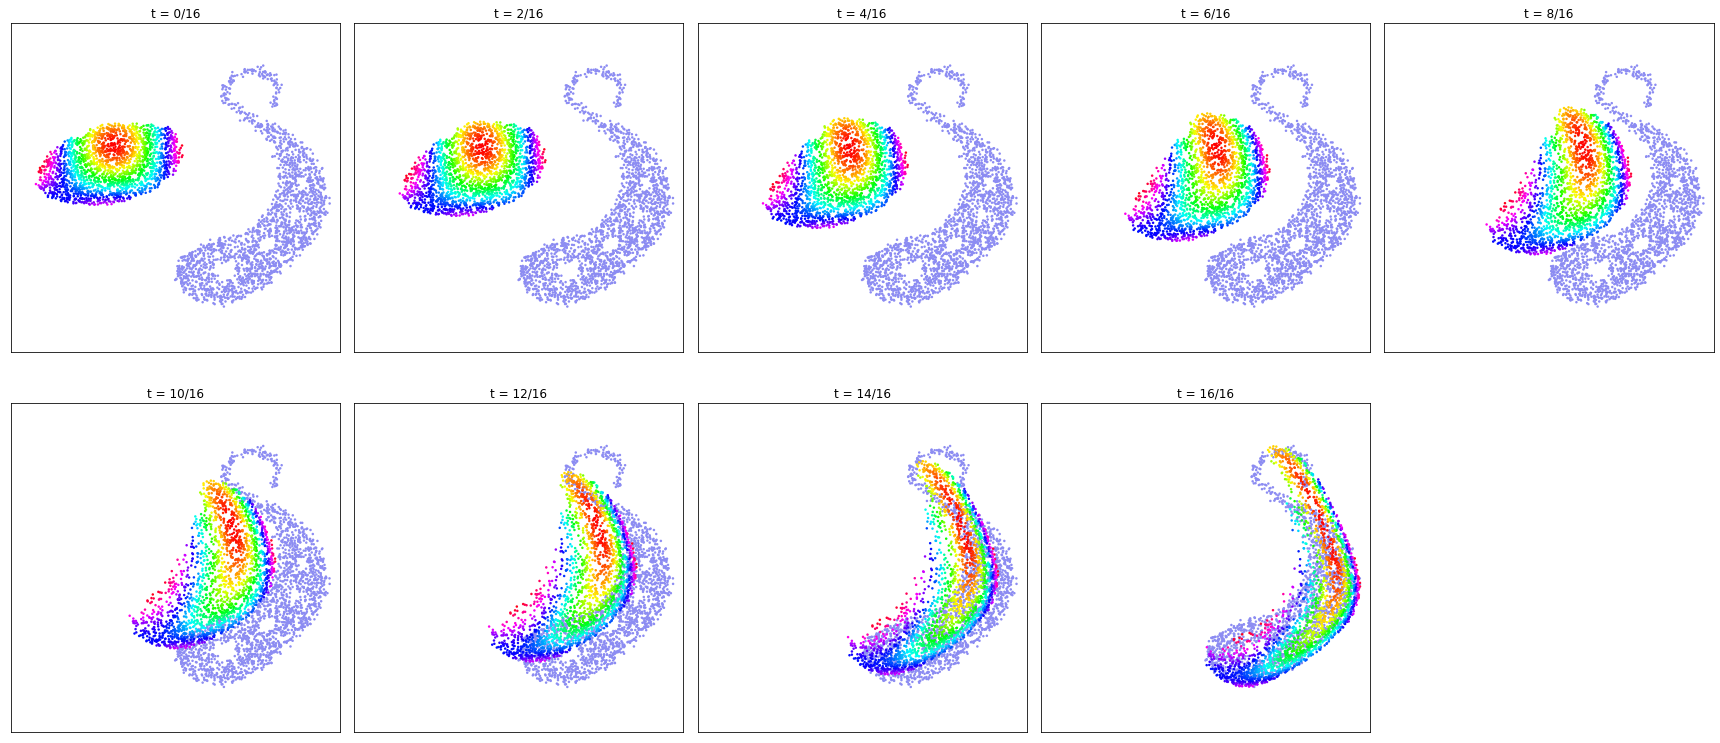

In [11]:
z_new = apply_diffeo(x_new,y_new,a,z,"unbiased_small_eps")

In [12]:
max_iter = 200
tol = 1e-8
lr = 0.5
S = SamplesLoss("sinkhorn", p=2, blur=0.1)

In [13]:
a,z = learn_diffeo(S,x,y,lamb,sigma,tau,lr,max_iter,tol)

Iteration: 0  Fidelity loss: 0.127193421125412  Objective: 0.127193421125412
Iteration: 1  Fidelity loss: 0.016903385519981384  Objective: 0.01690421812236309
Iteration: 2  Fidelity loss: 0.009045369923114777  Objective: 0.009046639315783978
Iteration: 3  Fidelity loss: 0.00614439882338047  Objective: 0.0061459350399672985
Iteration: 4  Fidelity loss: 0.004485404118895531  Objective: 0.004487120546400547
Iteration: 5  Fidelity loss: 0.0034038927406072617  Objective: 0.0034057325683534145
Iteration: 6  Fidelity loss: 0.002660208847373724  Objective: 0.0026621329598128796
Iteration: 7  Fidelity loss: 0.002136138267815113  Objective: 0.0021381184924393892
Iteration: 8  Fidelity loss: 0.0017628412460908294  Objective: 0.0017648575594648719
Iteration: 9  Fidelity loss: 0.0014957106905058026  Objective: 0.0014977488899603486
Iteration: 10  Fidelity loss: 0.0013037389144301414  Objective: 0.0013057891046628356
Iteration: 11  Fidelity loss: 0.001164610031992197  Objective: 0.001166665344499051

Iteration: 95  Fidelity loss: 0.00015245811664499342  Objective: 0.00015443757001776248
Iteration: 96  Fidelity loss: 0.00015145199722610414  Objective: 0.0001534311886643991
Iteration: 97  Fidelity loss: 0.0001504680549260229  Objective: 0.00015244698442984372
Iteration: 98  Fidelity loss: 0.00014950631884858012  Objective: 0.00015148498641792685
Iteration: 99  Fidelity loss: 0.00014856478082947433  Objective: 0.00015054320101626217
Iteration: 100  Fidelity loss: 0.00014764323714189231  Objective: 0.00014962140994612128
Iteration: 101  Fidelity loss: 0.00014674157137051225  Objective: 0.0001487194822402671
Iteration: 102  Fidelity loss: 0.00014585786266252398  Objective: 0.00014783552614971995
Iteration: 103  Fidelity loss: 0.00014499149983748794  Objective: 0.00014696893049404025
Iteration: 104  Fidelity loss: 0.0001441424828954041  Objective: 0.00014611966616939753
Iteration: 105  Fidelity loss: 0.0001433102006558329  Objective: 0.00014528713654726744
Iteration: 106  Fidelity loss: 

Iteration: 188  Fidelity loss: 0.00010146143904421479  Objective: 0.00010342971654608846
Iteration: 189  Fidelity loss: 0.00010112591553479433  Objective: 0.00010309422214049846
Iteration: 190  Fidelity loss: 0.00010079293861053884  Objective: 0.00010276127432007343
Iteration: 191  Fidelity loss: 0.00010046226088888943  Objective: 0.00010243063297821209
Iteration: 192  Fidelity loss: 0.00010013350402005017  Objective: 0.0001021019124891609
Iteration: 193  Fidelity loss: 9.98075120151043e-05  Objective: 0.00010177595686400309
Iteration: 194  Fidelity loss: 9.948344086296856e-05  Objective: 0.00010145192936761305
Iteration: 195  Fidelity loss: 9.916225099004805e-05  Objective: 0.00010113078315043822
Iteration: 196  Fidelity loss: 9.884266182780266e-05  Objective: 0.00010081123764393851
Iteration: 197  Fidelity loss: 9.85252991085872e-05  Objective: 0.00010049392585642636
Iteration: 198  Fidelity loss: 9.821077401284128e-05  Objective: 0.00010017945169238374
Iteration: 199  Fidelity loss:

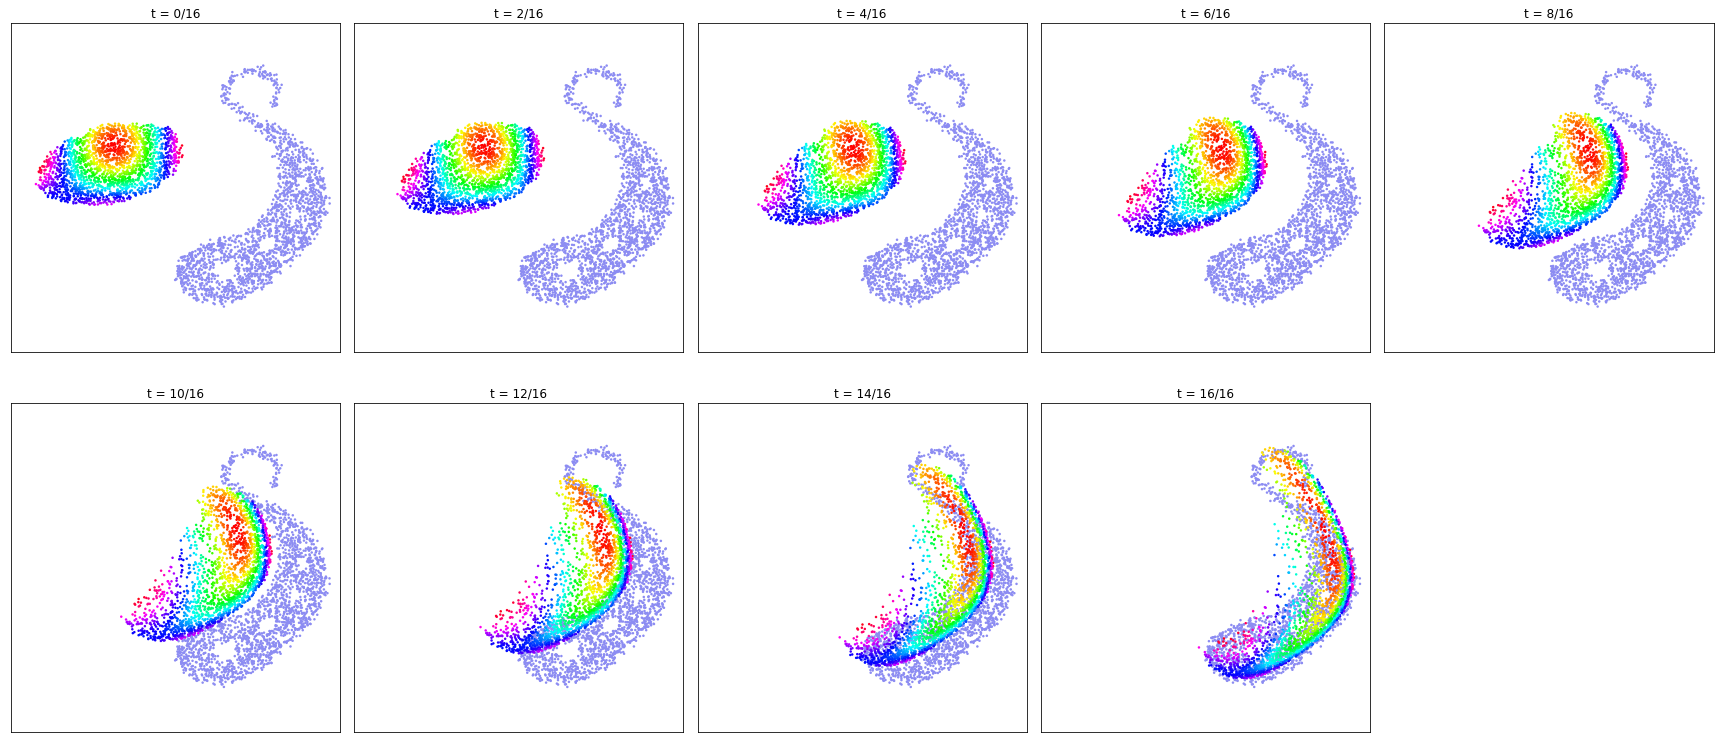

In [14]:
z_new = apply_diffeo(x_new,y_new,a,z,"unbiased_large_eps")

### 2.3.2. (Biased) regulatized OT cost

In [15]:
tau = 16
lamb = 1e-8
sigma = 0.175

In [16]:
max_iter = 200
tol = 1e-8
lr = 0.5
S = SamplesLoss("sinkhorn", p=2, blur=0.01, debias=False)

In [17]:
a,z = learn_diffeo(S,x,y,lamb,sigma,tau,lr,max_iter,tol)

Iteration: 0  Fidelity loss: 0.12794220447540283  Objective: 0.12794220447540283
Iteration: 1  Fidelity loss: 0.019057411700487137  Objective: 0.019058197736740112
Iteration: 2  Fidelity loss: 0.010192384012043476  Objective: 0.010193639434874058
Iteration: 3  Fidelity loss: 0.007187455426901579  Objective: 0.0071889981627464294
Iteration: 4  Fidelity loss: 0.005504014901816845  Objective: 0.005505752749741077
Iteration: 5  Fidelity loss: 0.0043941400945186615  Objective: 0.00439601531252265
Iteration: 6  Fidelity loss: 0.0036415811628103256  Objective: 0.003643553238362074
Iteration: 7  Fidelity loss: 0.0031183469109237194  Objective: 0.0031203879043459892
Iteration: 8  Fidelity loss: 0.0027474446687847376  Objective: 0.002749535022303462
Iteration: 9  Fidelity loss: 0.0024833902716636658  Objective: 0.0024855167139321566
Iteration: 10  Fidelity loss: 0.002295984420925379  Objective: 0.002298136707395315
Iteration: 11  Fidelity loss: 0.0021596828009933233  Objective: 0.002161853946745

Iteration: 97  Fidelity loss: 0.0009315566858276725  Objective: 0.0009337710798718035
Iteration: 98  Fidelity loss: 0.0009295556228607893  Objective: 0.0009317704825662076
Iteration: 99  Fidelity loss: 0.0009275565389543772  Objective: 0.0009297719225287437
Iteration: 100  Fidelity loss: 0.000925558153539896  Objective: 0.0009277740609832108
Iteration: 101  Fidelity loss: 0.0009235660545527935  Objective: 0.0009257824276573956
Iteration: 102  Fidelity loss: 0.0009215787285938859  Objective: 0.0009237955673597753
Iteration: 103  Fidelity loss: 0.0009196043247357011  Objective: 0.0009218216291628778
Iteration: 104  Fidelity loss: 0.0009176441817544401  Objective: 0.0009198619518429041
Iteration: 105  Fidelity loss: 0.0009157088352367282  Objective: 0.0009179270709864795
Iteration: 106  Fidelity loss: 0.0009137931629084051  Objective: 0.0009160118061117828
Iteration: 107  Fidelity loss: 0.0009119044407270849  Objective: 0.0009141235495917499
Iteration: 108  Fidelity loss: 0.00091004266869

Iteration: 192  Fidelity loss: 0.0007942229276522994  Objective: 0.0007964596152305603
Iteration: 193  Fidelity loss: 0.0007932024891488254  Objective: 0.0007954390603117645
Iteration: 194  Fidelity loss: 0.0007921952055767179  Objective: 0.000794431718531996
Iteration: 195  Fidelity loss: 0.0007912003202363849  Objective: 0.0007934367167763412
Iteration: 196  Fidelity loss: 0.0007902171928435564  Objective: 0.0007924535311758518
Iteration: 197  Fidelity loss: 0.0007892459980212152  Objective: 0.0007914822199381888
Iteration: 198  Fidelity loss: 0.0007882856880314648  Objective: 0.0007905217935331166
Iteration: 199  Fidelity loss: 0.0007873335271142423  Objective: 0.0007895695744082332
Elapsed time: 435.548654794693
Averaged elapsed time per iteration: 2.177743273973465


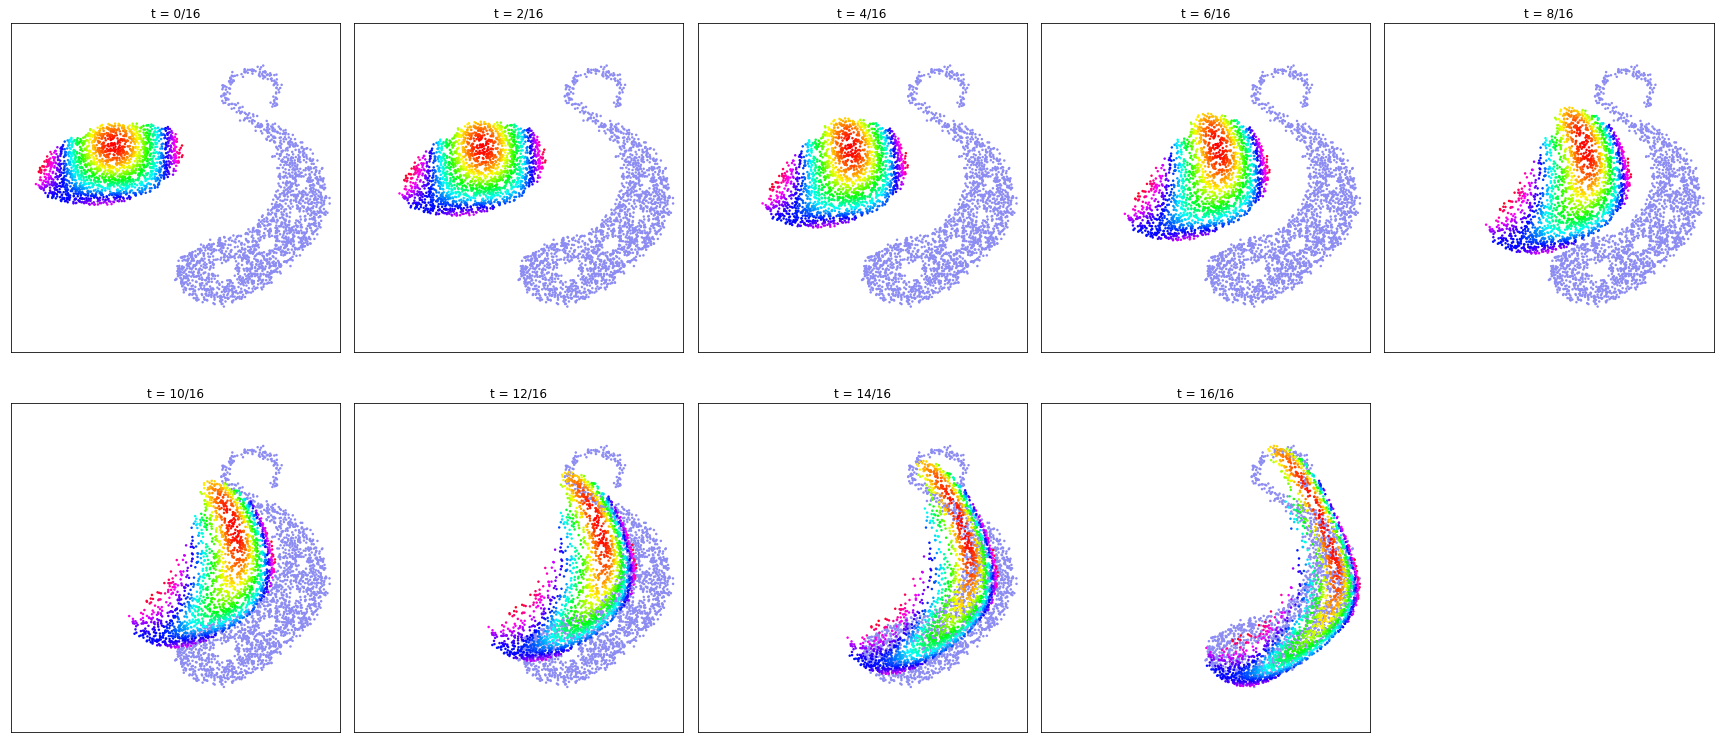

In [18]:
z_new = apply_diffeo(x_new,y_new,a,z,"biased_small_eps")

In [19]:
max_iter = 200
tol = 1e-8
lr = 0.5
S = SamplesLoss("sinkhorn", p=2, blur=0.1, debias=False)

In [20]:
a,z = learn_diffeo(S,x,y,lamb,sigma,tau,lr,max_iter,tol)

Iteration: 0  Fidelity loss: 0.13999974727630615  Objective: 0.13999974727630615
Iteration: 1  Fidelity loss: 0.02983211725950241  Objective: 0.029832961037755013
Iteration: 2  Fidelity loss: 0.023082636296749115  Objective: 0.02308392897248268
Iteration: 3  Fidelity loss: 0.020809825509786606  Objective: 0.020811377093195915
Iteration: 4  Fidelity loss: 0.01944575645029545  Objective: 0.01944747194647789
Iteration: 5  Fidelity loss: 0.018483832478523254  Objective: 0.018485652282834053
Iteration: 6  Fidelity loss: 0.017770985141396523  Objective: 0.017772870138287544
Iteration: 7  Fidelity loss: 0.017232883721590042  Objective: 0.0172348041087389
Iteration: 8  Fidelity loss: 0.01682285964488983  Objective: 0.016824796795845032
Iteration: 9  Fidelity loss: 0.016507748514413834  Objective: 0.016509689390659332
Iteration: 10  Fidelity loss: 0.016262799501419067  Objective: 0.01626473478972912
Iteration: 11  Fidelity loss: 0.01606939360499382  Objective: 0.016071317717432976
Iteration: 12

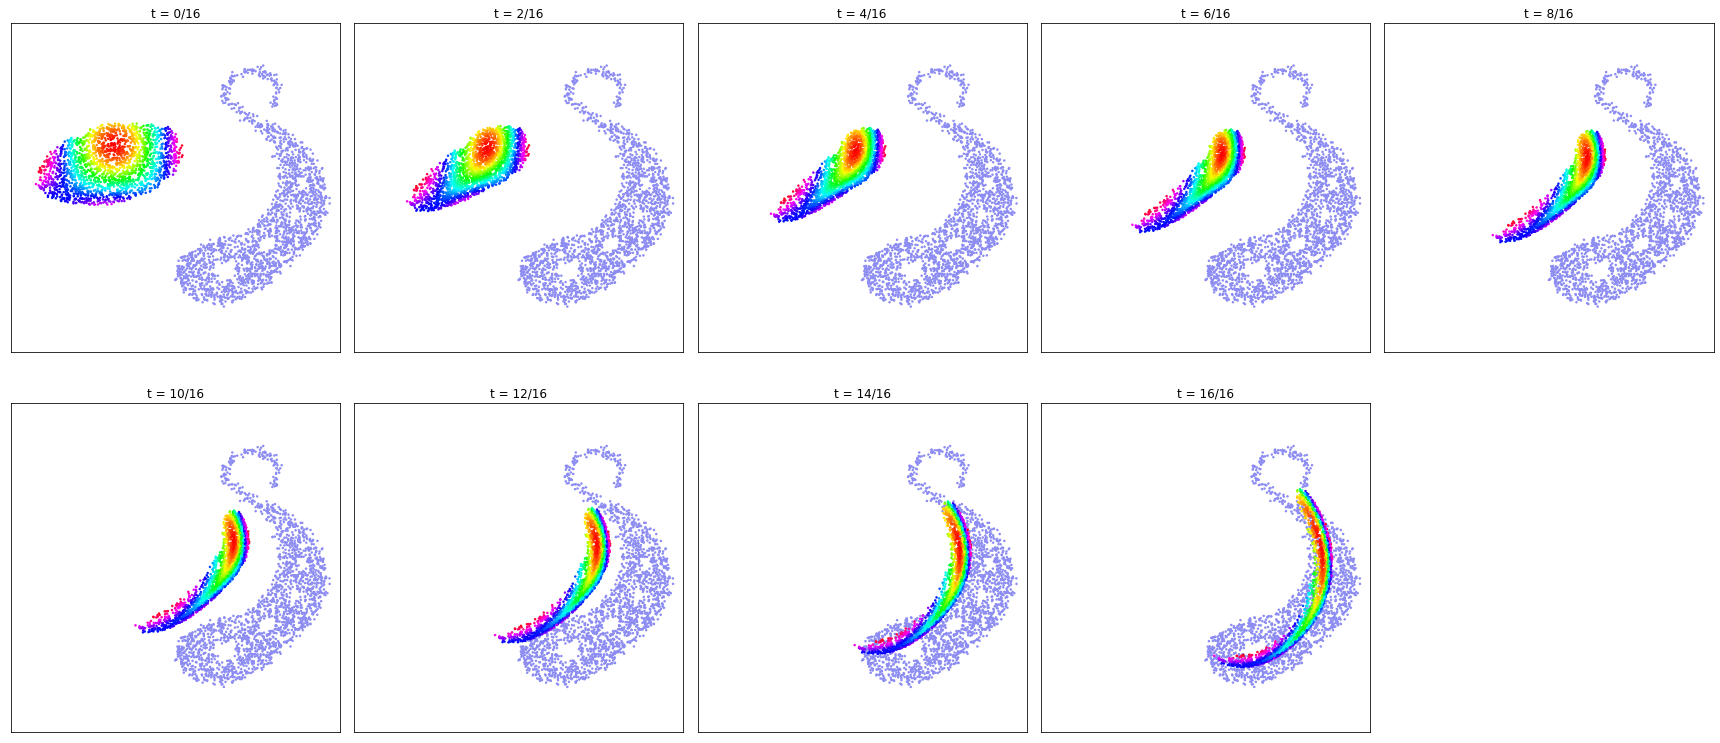

In [21]:
z_new = apply_diffeo(x_new,y_new,a,z,"biased_large_eps")

## 2.3.3. MMD

In [22]:
max_iter = 200
tol = 1e-8
lr = 0.1
L = SamplesLoss("gaussian", blur=0.5)

In [23]:
a,z = learn_diffeo(L,x,y,lamb,sigma,tau,lr,max_iter,tol)

Iteration: 0  Fidelity loss: 0.32914549112319946  Objective: 0.32914549112319946
Iteration: 1  Fidelity loss: 0.1723359227180481  Objective: 0.17233608663082123
Iteration: 2  Fidelity loss: 0.07811200618743896  Objective: 0.07811251282691956
Iteration: 3  Fidelity loss: 0.039988160133361816  Objective: 0.03998899459838867
Iteration: 4  Fidelity loss: 0.024882495403289795  Objective: 0.024883586913347244
Iteration: 5  Fidelity loss: 0.01796942949295044  Objective: 0.017970720306038857
Iteration: 6  Fidelity loss: 0.014285266399383545  Objective: 0.014286717399954796
Iteration: 7  Fidelity loss: 0.012047350406646729  Objective: 0.012048933655023575
Iteration: 8  Fidelity loss: 0.01053541898727417  Objective: 0.010537111200392246
Iteration: 9  Fidelity loss: 0.009424924850463867  Objective: 0.00942670926451683
Iteration: 10  Fidelity loss: 0.008555412292480469  Objective: 0.00855727307498455
Iteration: 11  Fidelity loss: 0.007841765880584717  Objective: 0.007843689061701298
Iteration: 12 

Iteration: 97  Fidelity loss: 0.00026875734329223633  Objective: 0.00027081285952590406
Iteration: 98  Fidelity loss: 0.00026237964630126953  Objective: 0.00026443545357324183
Iteration: 99  Fidelity loss: 0.0002561211585998535  Objective: 0.0002581772278062999
Iteration: 100  Fidelity loss: 0.00025022029876708984  Objective: 0.00025227662990801036
Iteration: 101  Fidelity loss: 0.0002446174621582031  Objective: 0.00024667399702593684
Iteration: 102  Fidelity loss: 0.00023889541625976562  Objective: 0.00024095212575048208
Iteration: 103  Fidelity loss: 0.00023359060287475586  Objective: 0.00023564747243653983
Iteration: 104  Fidelity loss: 0.00022834539413452148  Objective: 0.0002304023946635425
Iteration: 105  Fidelity loss: 0.00022333860397338867  Objective: 0.00022539572091773152
Iteration: 106  Fidelity loss: 0.00021851062774658203  Objective: 0.00022056783200241625
Iteration: 107  Fidelity loss: 0.00021380186080932617  Objective: 0.00021585913782473654
Iteration: 108  Fidelity los

Iteration: 191  Fidelity loss: 7.420778274536133e-05  Objective: 7.625397120136768e-05
Iteration: 192  Fidelity loss: 7.361173629760742e-05  Objective: 7.565780106233433e-05
Iteration: 193  Fidelity loss: 7.337331771850586e-05  Objective: 7.541926606791094e-05
Iteration: 194  Fidelity loss: 7.289648056030273e-05  Objective: 7.494231249438599e-05
Iteration: 195  Fidelity loss: 7.236003875732422e-05  Objective: 7.440576155204326e-05
Iteration: 196  Fidelity loss: 7.18832015991211e-05  Objective: 7.392880797851831e-05
Iteration: 197  Fidelity loss: 7.146596908569336e-05  Objective: 7.351146632572636e-05
Iteration: 198  Fidelity loss: 7.104873657226562e-05  Objective: 7.309412467293441e-05
Iteration: 199  Fidelity loss: 7.063150405883789e-05  Objective: 7.267678302014247e-05
Elapsed time: 144.05482840538025
Averaged elapsed time per iteration: 0.7202741420269012


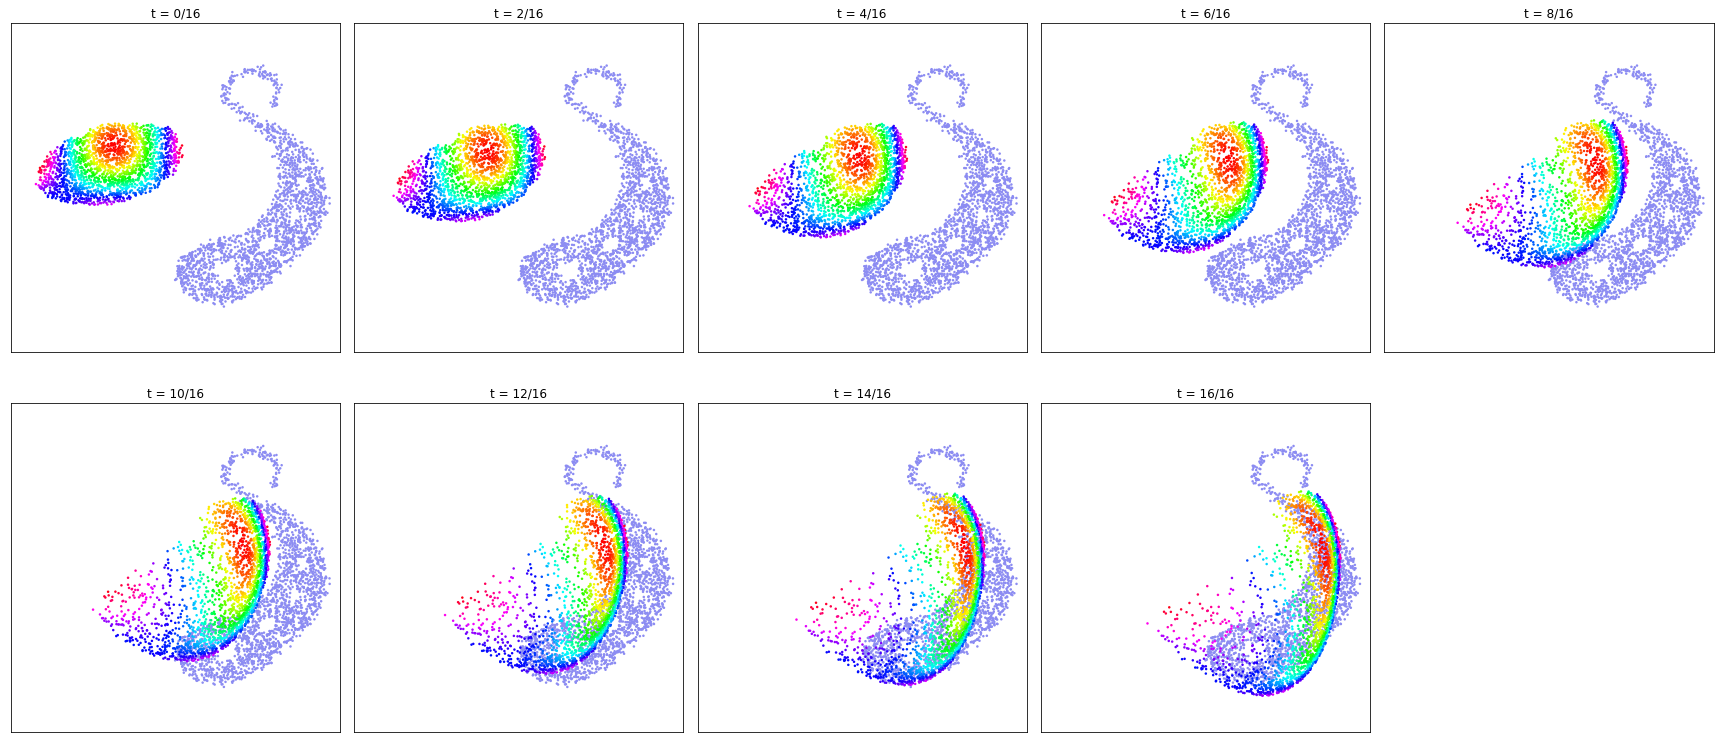

In [24]:
z_new = apply_diffeo(x_new,y_new,a,z,"large_bw")

In [25]:
max_iter = 200
tol = 1e-8
lr = 0.2
L = SamplesLoss("gaussian", blur=0.1)

In [26]:
a,z = learn_diffeo(L,x,y,lamb,sigma,tau,lr,max_iter,tol)

Iteration: 0  Fidelity loss: 0.3123335838317871  Objective: 0.3123335838317871
Iteration: 1  Fidelity loss: 0.1720173954963684  Objective: 0.1720173954963684
Iteration: 2  Fidelity loss: 0.13585491478443146  Objective: 0.13585492968559265
Iteration: 3  Fidelity loss: 0.09122606366872787  Objective: 0.09122616052627563
Iteration: 4  Fidelity loss: 0.07559547573328018  Objective: 0.0755956694483757
Iteration: 5  Fidelity loss: 0.06720656156539917  Objective: 0.06720677763223648
Iteration: 6  Fidelity loss: 0.06144985556602478  Objective: 0.06145010143518448
Iteration: 7  Fidelity loss: 0.055915363132953644  Objective: 0.05591563507914543
Iteration: 8  Fidelity loss: 0.05073324590921402  Objective: 0.050733547657728195
Iteration: 9  Fidelity loss: 0.04590319097042084  Objective: 0.0459035262465477
Iteration: 10  Fidelity loss: 0.04151491820812225  Objective: 0.0415152832865715
Iteration: 11  Fidelity loss: 0.03758953511714935  Objective: 0.03758993372321129
Iteration: 12  Fidelity loss: 0

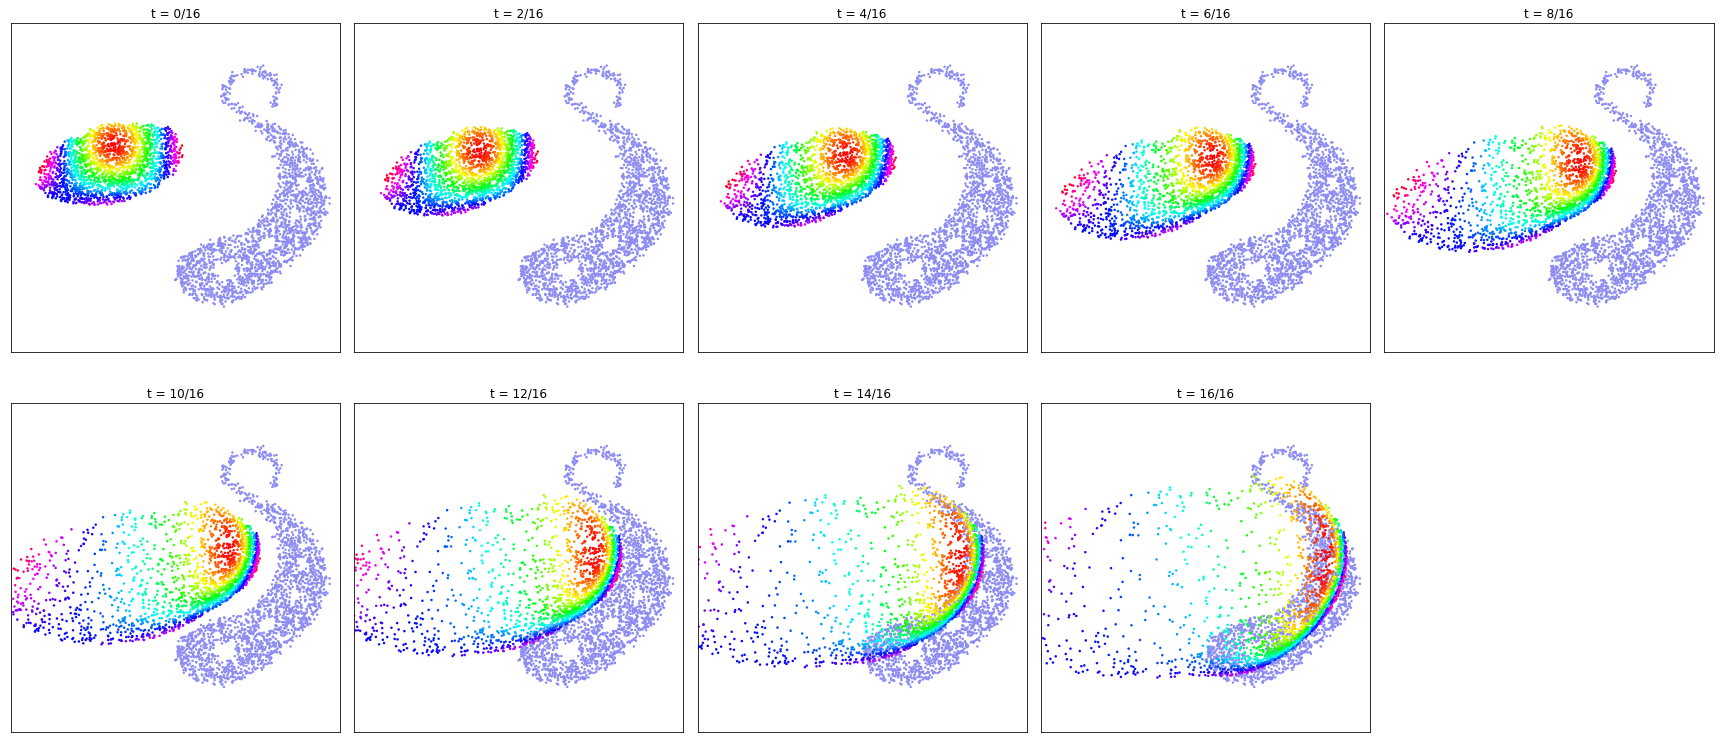

In [27]:
z_new = apply_diffeo(x_new,y_new,a,z,"small_bw")